<img src="../images/cmip6-cookbook-thumbnail.png" width=250 alt="CMIP6 image"></img>

# Estimating Equilibrium Climate Sensitivity

---

## Overview

Equilibrium Climate Sensitivity (ECS) is defined as change in global-mean near-surface air temperature (GMST) change due to an instantaneous doubling of CO$_2$ concentrations and once the coupled ocean-atmosphere-sea ice system has acheived a statistical equilibrium (i.e. at the top-of-atmosphere, incoming solar shortwave radiation is balanced by reflected solar shortwave and outgoing thermal longwave radiation).

This notebook uses the “[Gregory method]( https://doi.org/10.1029/2003GL018747)” to approximate the ECS of CMIP6 models based on the first 150 years after an abrupt doubling of CO$_2$
concentrations. The Gregory method extrapolates the quasi-linear relationship between GMST and radiative imbalance at the top-of-atmosphere to estimate how much warming would occur if the system were in radiative balance at the top-of-atmosphere, which is by definition the equilibrium response. In particular, we extrapolate the linear relationship that occurs between 100 and 150 years after the abrupt quadrupling. 

Since the radiative forcing due to CO$_2$ is a logarithmic function of the CO$_2$ concentration, the GMST change from a first doubling is roughly the same as for a second doubling (to first order, we can assume feedbacks as constant), which means that the GMST change due to a quadrupling of CO$_2$ is roughly $\Delta T_{4\times\mathrm{CO}_2}=2\times\mathrm{ECS}$. See also [Mauritsen et al. 2019](https://doi.org/10.1029/2018MS001400) for a detailed application of the Gregory method (with modifications) for the case of one specific CMIP6 model, the MPI-M Earth System Model.

For another take on applying the Gregory method to estimate ECS, see [Angeline Pendergrass’ code](https://github.com/apendergrass/cmip6-ecs).

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Dask | Helpful | |
| Climate sensitivity | Helpful | |

- **Time to learn**: 30 minutes

---

## Imports

In [1]:
from matplotlib import pyplot as plt
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
from dask_gateway import Gateway
from dask.distributed import Client

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

/tmp/ipykernel_1589/1804016931.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


## Compute Cluster

Here we use a dask cluster to parallelize our analysis.

In [2]:
platform = sys.platform

if (platform == 'win32'):
    import multiprocessing.popen_spawn_win32
else:
    import multiprocessing.popen_spawn_posix

Initiate the Dask client:

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 122.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42281,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 122.83 GiB
Comm: tcp://127.0.0.1:36961,Total threads: 4
Dashboard: http://127.0.0.1:45691/status,Memory: 15.35 GiB
Nanny: tcp://127.0.0.1:41345,


### Data catalogs
This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6).

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in Google Cloud Storage contains thousands of lines of metadata, each describing an individual climate model experiment’s simulated data.

For example, the first line in the `.csv` file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is forced by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F=7.0$ W m$^{-2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

## Use Intake-ESM

[Intake-ESM](https://intake-esm.readthedocs.io/en/stable/) is a new package designed to make working with these data archives a bit simpler.

In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


Here, we show the various forcing experiments that climate modellers ran in these simulations.

In [6]:
df['experiment_id'].unique()

array(['highresSST-present', 'piControl', 'control-1950', 'hist-1950',
       'historical', 'amip', 'abrupt-4xCO2', 'abrupt-2xCO2',
       'abrupt-0p5xCO2', '1pctCO2', 'ssp585', 'esm-piControl', 'esm-hist',
       'hist-piAer', 'histSST-1950HC', 'ssp245', 'hist-1950HC', 'histSST',
       'piClim-2xVOC', 'piClim-2xNOx', 'piClim-2xdust', 'piClim-2xss',
       'piClim-histall', 'hist-piNTCF', 'histSST-piNTCF',
       'aqua-control-lwoff', 'piClim-lu', 'histSST-piO3', 'piClim-CH4',
       'piClim-NTCF', 'piClim-NOx', 'piClim-O3', 'piClim-HC',
       'faf-heat-NA0pct', 'ssp370SST-lowCH4', 'piClim-VOC',
       'ssp370-lowNTCF', 'piClim-control', 'piClim-aer', 'hist-aer',
       'faf-heat', 'faf-heat-NA50pct', 'ssp370SST-lowNTCF',
       'ssp370SST-ssp126Lu', 'ssp370SST', 'ssp370pdSST', 'histSST-piAer',
       'piClim-ghg', 'piClim-anthro', 'faf-all', 'hist-nat', 'hist-GHG',
       'ssp119', 'piClim-histnat', 'piClim-4xCO2', 'ssp370',
       'piClim-histghg', 'highresSST-future', 'esm-ssp585-

## Loading Data

Intake-ESM enables loading data directly into an `xarray.DataArray`, a metadata-aware extension of numpy arrays. Xarray objects leverage [Dask](https://www.dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of Xarray Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [Zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) commonly used in the geosciences.

Intake-ESM has rules for aggegating datasets; these rules are defined in the collection-specification file.

Here, we choose the `piControl` experiment (in which CO$_2$ concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-2xCO2` experiment (in which CO$_2$ concentrations are instantaneously doubled from a pre-industrial control state). Since the radiative forcing of CO$_2$ is roughly a logarithmic function of CO$_2$ concentrations, the ECS is roughly independent of the initial CO$_2$ concentration. 

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
The version of this notebook in the 
<a href="http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/">Pangeo Gallery</a>
uses the <code>abrupt-4xCO2</code> forcing experiment, but fewer <code>abrupt-2xCO2</code> datasets are currently avaiable in Google Cloud Storage, which significantly reduces run time. If you want to run this notebook on your own computer with the <code>abrupt-4xCO2</code> experiment instead, change <code>co2_option</code> in the cell below. You will also need to take half of <code>ecs</code>, as described in the Overview. 
</div>

In [7]:
co2_option = 'abrupt-2xCO2'

## Prepare Data

In [8]:
query = dict(
    experiment_id=[co2_option,'piControl'], # pick the `abrupt-2xCO2` and `piControl` forcing experiments
    table_id='Amon',                            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=['tas', 'rsut','rsdt','rlut'],  # choose to look at near-surface air temperature (tas) as our variable
    member_id = 'r1i1p1f1',                     # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


,experiment_id,variable_id,table_id
source_id,,,
CESM2,2,4,1
GISS-E2-1-G,2,4,1
GISS-E2-1-H,2,4,1
GISS-E2-2-G,2,4,1
IPSL-CM6A-LR,2,4,1
MIROC6,2,4,1
MRI-ESM2-0,2,4,1


The following functions help us load and homogenize the data. We use some [`dask.delayed`](https://docs.dask.org/en/latest/delayed.html) programming to open the datasets in parallel.

In [9]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None

def open_delayed(df):
    """A dask.delayed wrapper around `open_dsets`.
    Allows us to open many datasets in parallel."""
    return dask.delayed(open_dsets)(df)

Create a nested dictionary of models and experiments. It will be structured like this:
```
{'CESM2':
  {
    'piControl': <xarray.Dataset>,
    'abrupt-2xCO2': <xarray.Dataset>
  },
  ...
}
```

In [10]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

Open one of the datasets directly, just to show what it looks like:

In [11]:
%time open_dsets(df)

CPU times: user 2.39 s, sys: 326 ms, total: 2.72 s
Wall time: 11.4 s


<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320, time: 8412)
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 1850-01-16 00:00:00 ... 2550-12-16 00:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(600, 160, 320), meta=np.ndarray>
    rsut     (time, lat, lon) float32 dask.array<chunksize=(600, 160, 320), meta=np.ndarray>
    rsdt     (time, lat, lon) float32 dask.array<chunksize=(600, 160, 320), meta=np.ndarray>
    rlut     (time, lat, lon) float32 dask.array<chunksize=(600, 160, 320), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  365243.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/a0bd7d8f-4785-4687-b510-fd87808051b6
    variable_id:            tas
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a0bd7d8f-4785-4687-b510-fd87808051b6
    version_id:             v20190222

Now use dask to do this in parallel on all of the datasets:

In [12]:
dsets_ = dask.compute(dict(dsets))[0]

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: 

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: 

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode tim

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


## Reduce Data via Global Mean

We don’t want to load all of the raw model data into memory right away. Instead, we want to reduce the data by taking the global mean. We need to remember to weight this global mean by a factor proportional to `cos(lat)`.

In [13]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

We now apply this function, plus resampling to annual mean data, to all of the datasets. We also concatenate the experiments together into a single Dataset for each model. This is the most complex cell in the notebook. A lot is happening here.

In [14]:
expts = ['piControl', co2_option]
expt_da = xr.DataArray(expts, dims='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year - ds.time.dt.year[0]

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 2xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='right',
                                 dim=expt_da)

  0%|          | 0/7 [00:00<?, ?it/s]

## Do the Computation

Up to this point, no computations have actually happened. Everything has been “lazy”. Now we trigger the computation to actual occur and load the global/annual mean data into memory.

In [15]:
dsets_aligned_ = dask.compute(dsets_aligned)[0]

Now we concatenate across models to produce one big dataset with all the required variables.

In [16]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                   dim=source_da)
big_ds

<xarray.Dataset>
Dimensions:        (year: 250, experiment_id: 2, source_id: 7)
Coordinates:
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 246.0 247.0 248.0 249.0
  * experiment_id  (experiment_id) <U12 'piControl' 'abrupt-2xCO2'
  * source_id      (source_id) <U12 'CESM2' 'GISS-E2-1-G' ... 'MRI-ESM2-0'
Data variables:
    rsut           (source_id, experiment_id, year) float64 99.36 99.8 ... nan
    tas            (source_id, experiment_id, year) float64 287.0 287.1 ... nan
    rsdt           (source_id, experiment_id, year) float64 340.3 340.3 ... nan
    rlut           (source_id, experiment_id, year) float64 240.2 240.5 ... nan

## Calculated Derived Variables

We need to calculate the net radiative imbalance, plus the anomaly of the abrupt 2xCO2 run compared to the piControl run.

In [17]:
big_ds['imbalance'] = big_ds['rsdt'] - big_ds['rsut'] - big_ds['rlut']

ds_mean = big_ds[['tas', 'imbalance']].sel(experiment_id='piControl').mean(dim='year')
ds_anom = big_ds[['tas', 'imbalance']] - ds_mean

# add some metadata
ds_anom.tas.attrs['long_name'] = 'Global Mean Surface Temp Anom'
ds_anom.tas.attrs['units'] = 'K'
ds_anom.imbalance.attrs['long_name'] = 'Global Mean Radiative Imbalance'
ds_anom.imbalance.attrs['units'] = 'W m$^{-2}$'

ds_anom

<xarray.Dataset>
Dimensions:        (year: 250, experiment_id: 2, source_id: 7)
Coordinates:
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 246.0 247.0 248.0 249.0
  * experiment_id  (experiment_id) <U12 'piControl' 'abrupt-2xCO2'
  * source_id      (source_id) <U12 'CESM2' 'GISS-E2-1-G' ... 'MRI-ESM2-0'
Data variables:
    tas            (source_id, experiment_id, year) float64 0.06312 ... nan
    imbalance      (source_id, experiment_id, year) float64 -0.04953 ... nan

## Plot Timeseries

Here we plot the global mean surface temperature for each model:

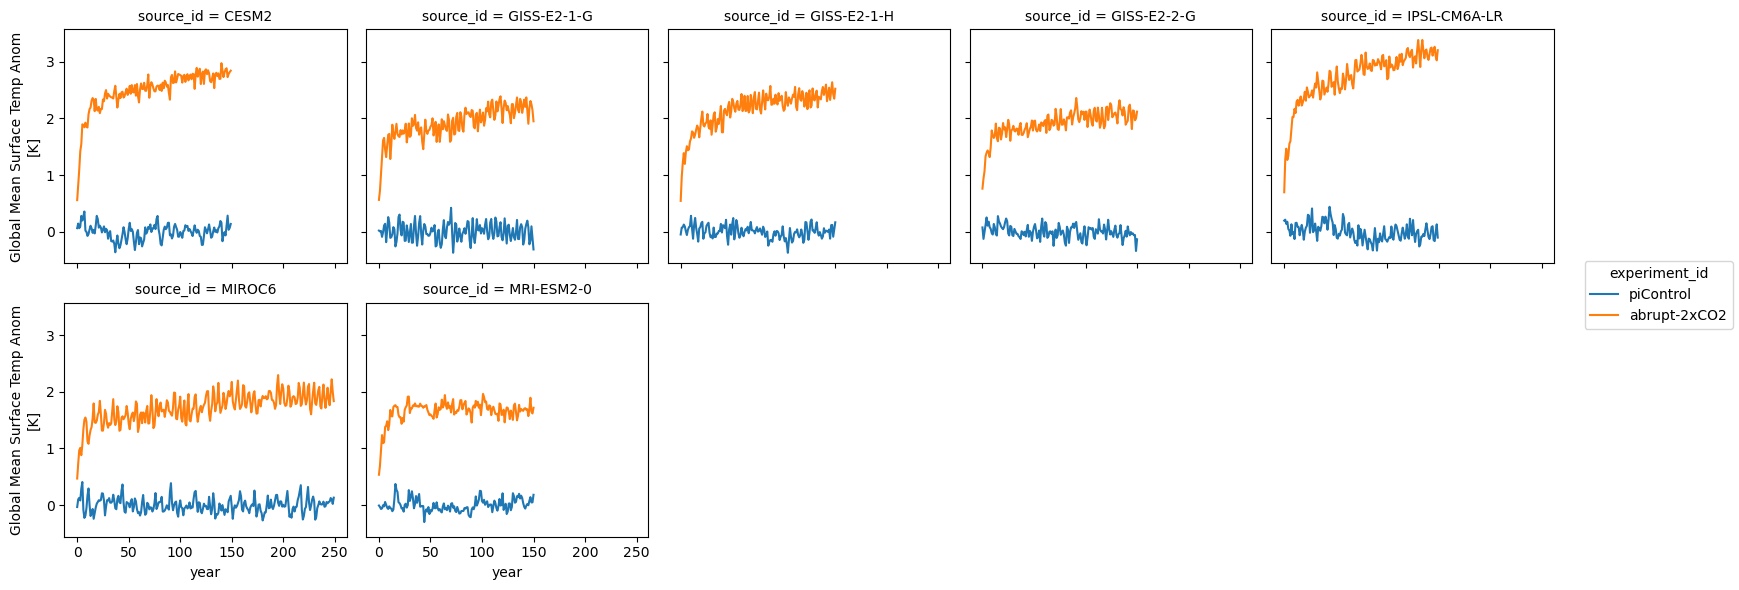

In [18]:
ds_anom.tas.plot.line(col='source_id', x='year', col_wrap=5)

We can see that the models cover different time intervals. Let’s limit the rest of our analysis to the first 150 years.

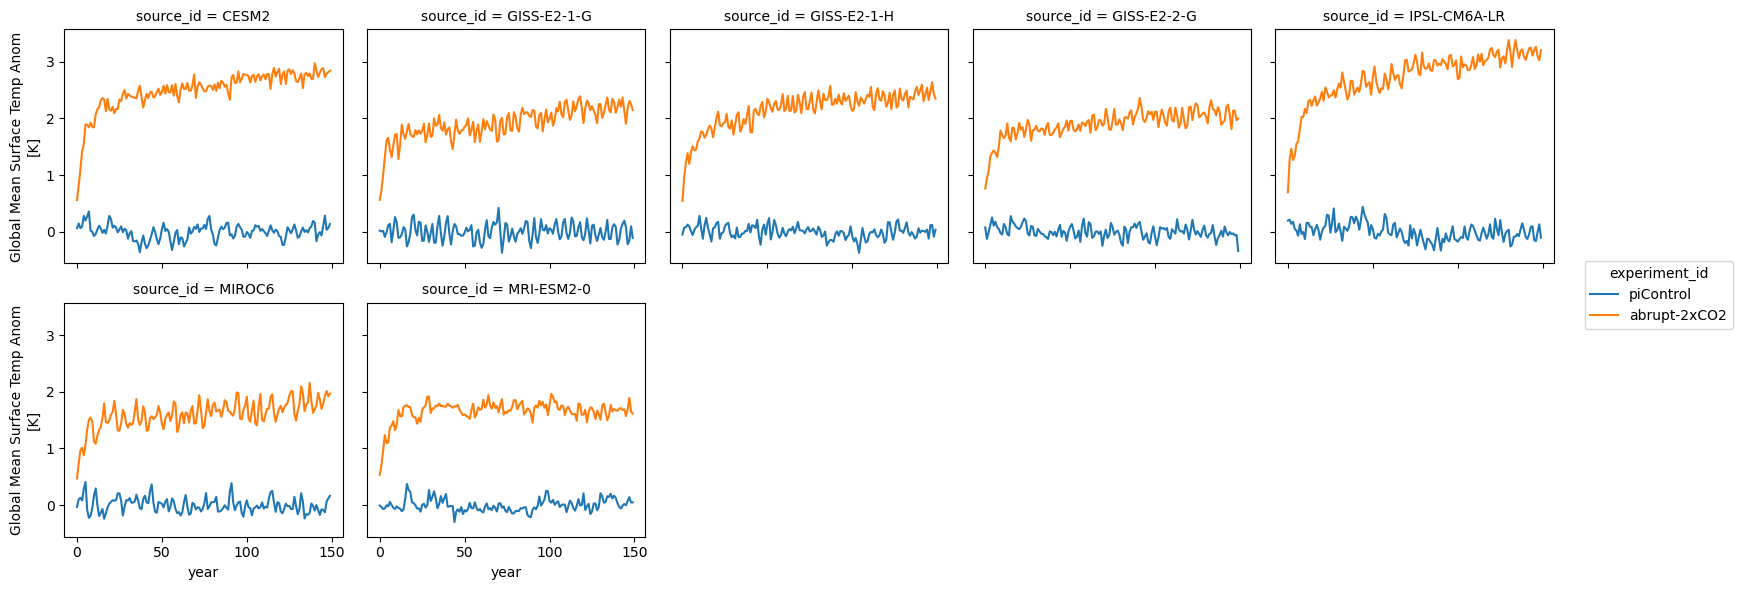

In [19]:
first_150_years = slice(0, 149)
ds_anom.tas.sel(year=first_150_years).plot.line(col='source_id', x='year', col_wrap=5)

Same thing for radiative imbalance:

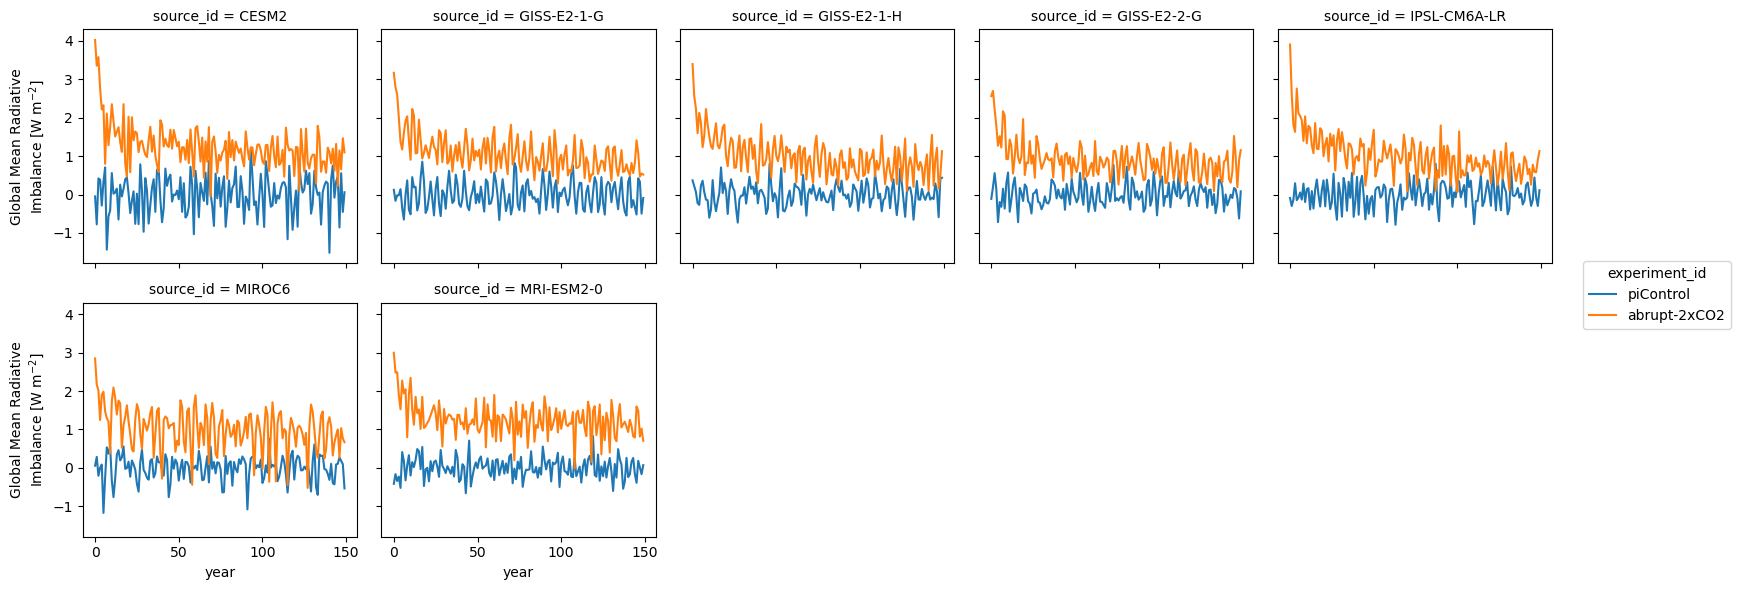

In [20]:
ds_anom.imbalance.sel(year=first_150_years).plot.line(col='source_id', x='year', col_wrap=5)

## Calculate ECS

In [21]:
ds_abrupt = ds_anom.sel(year=first_150_years, experiment_id=co2_option).reset_coords(drop=True)

def calc_ecs(ds):
    # Some sources don't have all 150 years, drop those missing values.
    a, b = np.polyfit(ds.tas.dropna("year"),
                      ds.imbalance.dropna("year"), 1)
    ecs = -1.0 * (b/a) # Change -1.0 to -0.5 if using 4xCO2
    return xr.DataArray(ecs)

ds_abrupt['ecs'] = ds_abrupt.groupby('source_id').apply(calc_ecs)
ds_abrupt.compute()

<xarray.Dataset>
Dimensions:    (year: 150, source_id: 7)
Coordinates:
  * year       (year) float64 0.0 1.0 2.0 3.0 4.0 ... 146.0 147.0 148.0 149.0
  * source_id  (source_id) <U12 'CESM2' 'GISS-E2-1-G' ... 'MIROC6' 'MRI-ESM2-0'
Data variables:
    tas        (source_id, year) float64 0.5582 0.8175 1.095 ... 1.646 1.616
    imbalance  (source_id, year) float64 4.026 3.355 3.579 ... 1.022 0.7031
    ecs        (source_id) float64 3.526 2.659 2.932 2.501 3.827 2.235 2.552

Reproduce a plot similar to [Mark Zelinka’s](https://twitter.com/mzelinka/status/1255534531144085513):

Also, make sure that we set a couple of the variables to be coordinates.

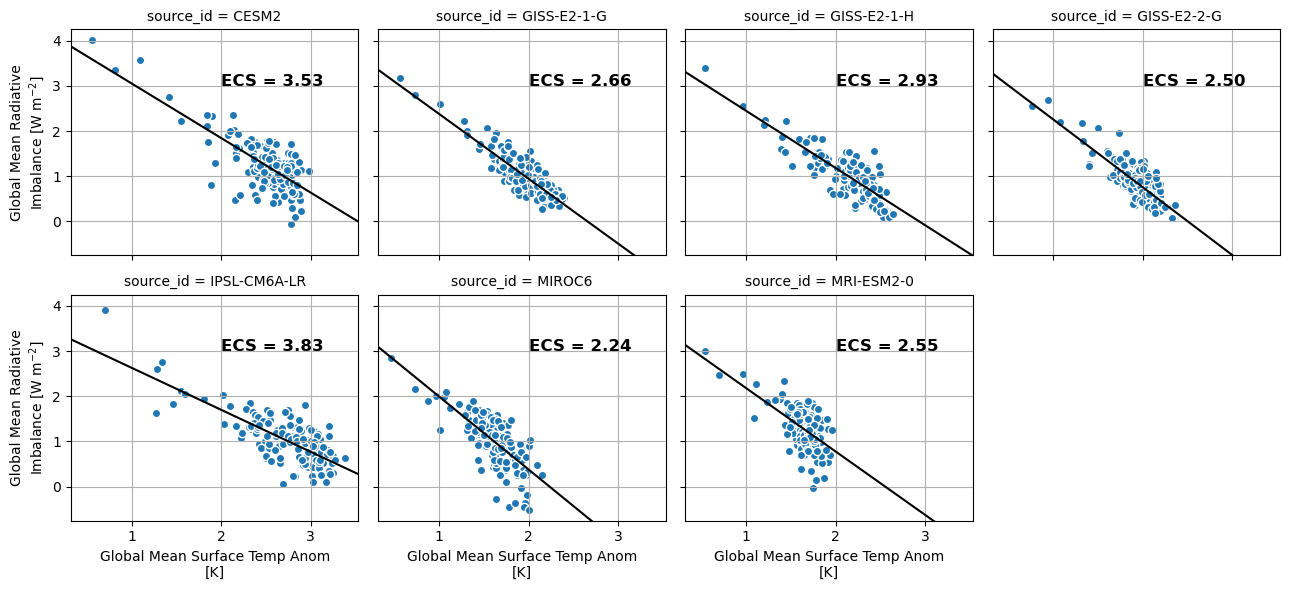

In [22]:
ds_abrupt = ds_abrupt.set_coords(['tas', 'imbalance'])

fg = ds_abrupt.plot.scatter(x='tas', y='imbalance', col='source_id', col_wrap=4, add_colorbar=False)

def calc_and_plot_ecs(x, y, **kwargs):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    a, b = np.polyfit(x, y, 1)
    ecs = -1.0 * b/a
    plt.autoscale(False)
    plt.plot([0, 10], np.polyval([a, b], [0, 10]), 'k')
    plt.text(2, 3, f'ECS = {ecs:3.2f}', fontdict={'weight': 'bold', 'size': 12})
    plt.grid()

fg.map(calc_and_plot_ecs, 'tas', 'imbalance')

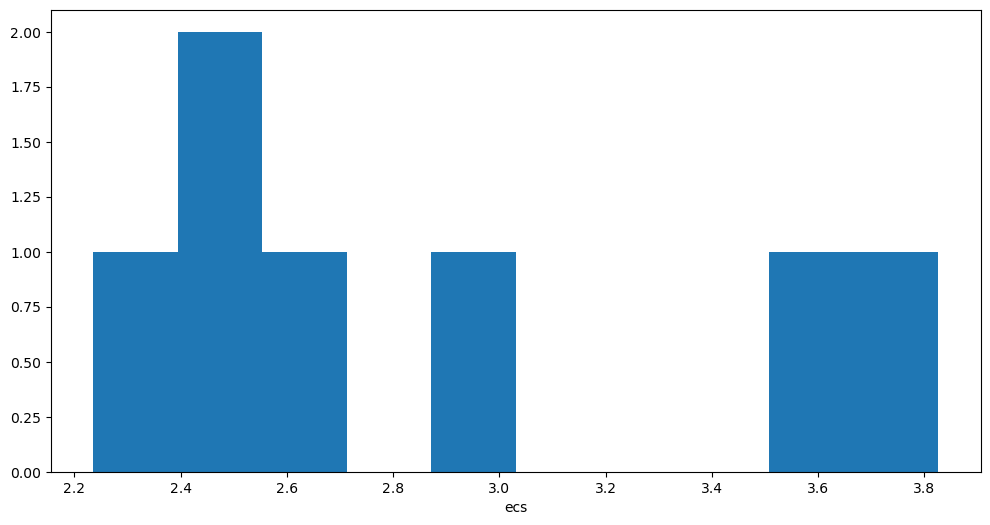

In [23]:
ds_abrupt.ecs.plot.hist();

<Axes: xlabel='source_id'>

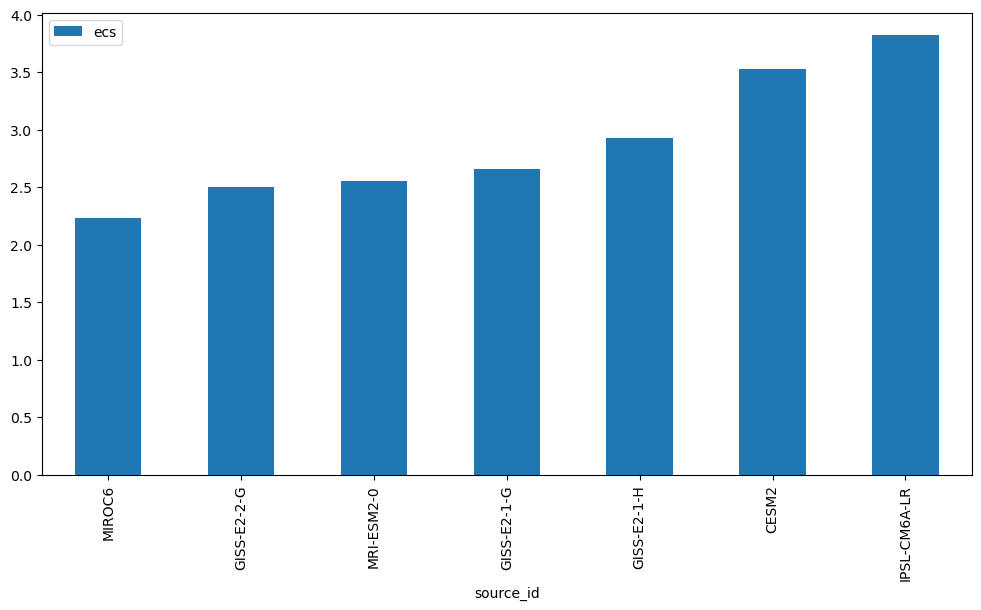

In [24]:
ds_abrupt.ecs.to_dataframe().sort_values('ecs').plot(kind='bar')

We're at the end of the notebook, so let's shutdown our Dask cluster.

In [25]:
client.shutdown()

---

## Summary
In this notebook, we estimated ECS for a subset of CMIP6 models using the Gregory method.

### What's next?
We will plot global average surface air temperature for a historical run and two branching emissions scenarios.

## Resources and references
- [Original notebook in the Pangeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/ECS_Gregory_method.html) by Henri Drake and [Ryan Abernathey](https://ocean-transport.github.io/)